# **Preparación ambiente**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

# **Importación dataset**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ProyectosDHDS-main/TP3/data/patient.csv", sep = ",", low_memory=False) 

In [ ]:
#data=pd.read_csv("../Data/patient.csv")

In [ ]:
print(data.nunique())
print(data.shape)

sex                         2
patient_type                2
intubated                   4
pneumonia                   3
age                       104
pregnant                    4
diabetes                    3
copd                        2
asthma                      2
immunosuppression           2
hypertension                2
other_diseases              3
cardiovascular              2
obesity                     2
chronic_kidney_failure      3
smoker                      2
outcome                     3
icu                         4
death_date                 54
dtype: int64
(95252, 19)


# **Target Patient Type**

## *Preparación Datos Target Patient Type*

In [ ]:
#Dropeo icu, intubated, death_date
dataPT=data.drop(['icu','intubated','death_date'], axis=1)
print(dataPT.columns)
dataPT.shape

Index(['sex', 'patient_type', 'pneumonia', 'age', 'pregnant', 'diabetes',
       'copd', 'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'outcome'],
      dtype='object')


(95252, 16)

In [ ]:
#99 a null y dropeo
cols=dataPT.columns.difference(['age'])

df=(dataPT[cols] == 99)
ix=df[df.any(axis=1)].index
print(ix)
dataPT.drop(df.index[ix], axis=0, inplace=True)
dataPT.shape

Int64Index([161, 174, 592, 609, 644, 13322, 15671, 27316], dtype='int64')


(95244, 16)

In [ ]:
#Renombro columnas
dataPT.rename(columns={"patient_type": "inpatient", "outcome": "covid"},inplace=True)

In [ ]:
#Para predictivas: 1 -> Y, 2 -> N, 
cols = dataPT.loc[:, dataPT.columns.difference(['age', 'sex','inpatient'])].columns
#print(cols) 
dataPT[cols] = dataPT[cols].replace([1,2],['Y','N'])

#en sex: 1 -> F y 2-> M
dataPT['sex']= dataPT['sex'].replace([1,2],['F','M'])

#en pregnant : 98 -> N, 97 -> NA
dataPT['pregnant'] = dataPT['pregnant'].replace([98,97],['N','NA'])

# outcome: 3 -> NA
dataPT['covid'] = dataPT['covid'].replace([3],['NA'])

##Para target (inpatient): 1 -> 0, 2 -> 1
dataPT['inpatient']= dataPT['inpatient'].replace([1,2],[0,1])
dataPT.head(5)

,sex,inpatient,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,covid
0,M,0,N,42,NA,N,N,Y,N,N,N,N,N,N,N,Y
1,F,0,N,51,N,N,N,N,N,N,N,N,N,N,N,Y
2,M,1,N,51,NA,Y,N,N,N,Y,N,N,Y,N,N,Y
3,M,1,N,57,NA,Y,N,N,N,N,N,N,N,N,N,Y
4,F,1,N,44,N,Y,N,N,N,N,N,N,N,N,N,N


In [ ]:
dataPT.groupby(["sex","pregnant"])["pregnant"].count()

sex  pregnant
F    N           45914
     Y             976
M    NA          48354
Name: pregnant, dtype: int64

In [ ]:
#creo categorias para edad por décadas (puede ser por etapa biologica niños-jovenes-adultos-ancianos)
dataPT = dataPT.assign(agegroup=pd.cut(dataPT['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False, labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99"]))

In [ ]:
dataPT.columns

Index(['sex', 'inpatient', 'pneumonia', 'age', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid', 'agegroup'],
      dtype='object')

In [ ]:
#elimino age para no tener dummies
dataPT.drop(["age"], axis=1, inplace=True)

In [ ]:
dataPT.columns

Index(['sex', 'inpatient', 'pneumonia', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid', 'agegroup'],
      dtype='object')

In [ ]:
#creo variables dummies de todas las columnas menos la target
dataPT = pd.get_dummies(data=dataPT, columns= dataPT.columns.difference(["inpatient"]),drop_first = True)

In [ ]:
dataPT.columns

Index(['inpatient', 'agegroup_10-19', 'agegroup_20-29', 'agegroup_30-39',
       'agegroup_40-49', 'agegroup_50-59', 'agegroup_60-69', 'agegroup_70-79',
       'agegroup_80-89', 'agegroup_90-99', 'asthma_Y', 'cardiovascular_Y',
       'chronic_kidney_failure_N', 'chronic_kidney_failure_Y', 'copd_Y',
       'covid_NA', 'covid_Y', 'diabetes_N', 'diabetes_Y', 'hypertension_Y',
       'immunosuppression_Y', 'obesity_Y', 'other_diseases_N',
       'other_diseases_Y', 'pneumonia_Y', 'pregnant_NA', 'pregnant_Y', 'sex_M',
       'smoker_Y'],
      dtype='object')

## *Creación variables X e Y Target Patient Type*

Eliminamos las columnas death_date, intubated y icu (por su correlación lineal con intubated)

In [ ]:
x=dataPT.drop(["inpatient"],axis=1)
y=dataPT["inpatient"]
y=pd.DataFrame(y)
y

,inpatient
0,0
1,0
2,1
3,1
4,1
...,...
95247,1
95248,1
95249,1
95250,0


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y, random_state = 123)
print ("X_train:" , x_train.shape[0])
print ("y_train:" , y_train.shape[0])
print ("X_test:" , x_test.shape[0])
print ("y_test:" , y_test.shape[0])

X_train: 71433
y_train: 71433
X_test: 23811
y_test: 23811


In [ ]:
y_train=pd.DataFrame(y_train)
y_train

,inpatient
80255,0
83772,0
45338,0
10114,1
8055,1
...,...
43426,1
46390,0
46520,0
26934,0


## *Logistic Regression Target Patient Type*

In [ ]:
#Logistic regression
#scaler = StandardScaler()
#x_trainstd = scaler.fit_transform(x_train)
#x_teststd = scaler.transform(x_test)
lr = LogisticRegression(class_weight="balance")
lr.fit(x_train, y_train)
score_lr= lr.score(x_test, y_test)

In [ ]:
print ("Logistic Regression Score:", score_lr)

Logistic Regression Score: 0.8701020536726723


In [ ]:
y_pred_lr = lr.predict(x_test)

In [ ]:
print("Accuracy Score LR:\n", accuracy_score(y_test, y_pred_lr))

Accuracy Score LR:
 0.8701020536726723


In [ ]:
print("Confusion Matrix LR:\n", confusion_matrix(y_test, y_pred_lr))

Confusion Matrix LR:
 [[16713   779]
 [ 2314  4005]]


In [ ]:
lr.intercept_

array([0.57593842])

In [ ]:
lr.coef_

array([[-1.18232565, -1.90317199, -1.8656363 , -1.51042501, -1.09246452,
        -0.66593445, -0.17053997,  0.23584377,  0.57435401, -0.10017775,
         0.16222284, -0.17883963,  1.03227014,  0.69238372,  0.434195  ,
         0.65507028, -0.98875884, -0.34777642,  0.16716825,  0.92237024,
         0.18090474, -0.69410429, -0.13987588,  3.48151651,  0.1562873 ,
         1.70819275,  0.1562873 ,  0.05162144]])

In [ ]:
print("Logistic Regression:\n", classification_report(y_test,y_pred_lr))

Logistic Regression:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     17492
           1       0.84      0.63      0.72      6319

    accuracy                           0.87     23811
   macro avg       0.86      0.79      0.82     23811
weighted avg       0.87      0.87      0.86     23811



In [ ]:
importance = lr.coef_.flatten()

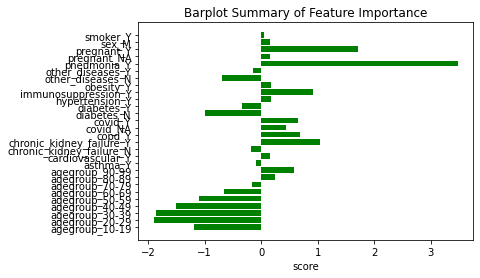

In [ ]:
plt.barh(x.columns,importance,color="g")
plt.title("Barplot Summary of Feature Importance")
plt.xlabel("score")
plt.show()

In [ ]:
#LR
probs_lr=lr.predict_proba(x_test)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

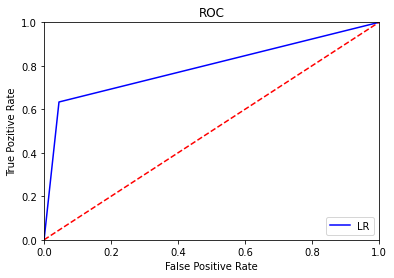

In [ ]:
plt.title("ROC")

plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_lr)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## *Machine Learning Algorithms Target Patient Type*

In [ ]:
#Naive Bayes
nb=MultinomialNB()
nb.fit(x_train, y_train)
score_nb=nb.score(x_test,y_test)

#KNN (poner en n_neighbors el best_params_ de GridSearch)
knn=KNeighborsClassifier(n_neighbors=20)
knn.fit(x_train,y_train)
score_knn=knn.score(x_test,y_test)

#Logistic regression
scaler = StandardScaler()
x_trainstd = scaler.fit_transform(x_train)
x_teststd = scaler.transform(x_test)
lr = LogisticRegression()
lr.fit(x_trainstd, y_train)
score_lr= lr.score(x_teststd, y_test)

#Tree Classification
clftree = tree.DecisionTreeClassifier(random_state=40)
clftree.fit(x_train, y_train)
score_t = clftree.score(x_test, y_test)

#Score
print ("Naive Bayes Acc Score:",score_nb)
print ("KNN Acc Score:",score_knn)
print ("Logistic Regression Score:", score_lr)
print("Tree classification Score:", score_t)

Naive Bayes Acc Score: 0.8467934988030742
KNN Acc Score: 0.8636764520599722
Logistic Regression Score: 0.8744277854773004
Tree classification Score: 0.8657763218680442


In [ ]:
y_pred_nb = nb.predict(x_test)
y_pred_knn = knn.predict(x_test)
y_pred_lr = lr.predict(x_teststd)
y_pred_t = clftree.predict(x_test)

In [ ]:
print("AS NB:\n", accuracy_score(y_test, y_pred_nb))
print("AS KNN:\n", accuracy_score(y_test, y_pred_knn))
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))
print("T LR:\n", accuracy_score(y_test, y_pred_t))

AS NB:
 0.8467934988030742
AS KNN:
 0.8636764520599722
AS LR:
 0.8744277854773004
T LR:
 0.8657763218680442


### Confusion_matrix Target Patient Type

In [ ]:
print("CM NB:\n", confusion_matrix(y_test, y_pred_nb))
print("CM KNN:\n", confusion_matrix(y_test, y_pred_knn))
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))
print("T LR:\n", confusion_matrix(y_test, y_pred_t))

CM NB:
 [[15955  1537]
 [ 2111  4208]]
CM KNN:
 [[16568   924]
 [ 2322  3997]]
CM LR:
 [[16717   775]
 [ 2215  4104]]
T LR:
 [[16557   935]
 [ 2261  4058]]


### Recall,Precision and F-1 Score Target Patient Type


* Recall    =  TP / (TP + FN)
* Precision = TP / (TP + FP) 
* F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [ ]:
print("NB:\n", classification_report(y_test,y_pred_nb))
print("KNN:\n", classification_report(y_test,y_pred_knn))
print("LR:\n", classification_report(y_test,y_pred_lr))
print("T:\n", classification_report(y_test,y_pred_t))

NB:
               precision    recall  f1-score   support

           0       0.88      0.91      0.90     17492
           1       0.73      0.67      0.70      6319

    accuracy                           0.85     23811
   macro avg       0.81      0.79      0.80     23811
weighted avg       0.84      0.85      0.84     23811

KNN:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91     17492
           1       0.81      0.63      0.71      6319

    accuracy                           0.86     23811
   macro avg       0.84      0.79      0.81     23811
weighted avg       0.86      0.86      0.86     23811

LR:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     17492
           1       0.84      0.65      0.73      6319

    accuracy                           0.87     23811
   macro avg       0.86      0.80      0.83     23811
weighted avg       0.87      0.87      0.87     23811

T:


In [ ]:
print ("F1 Score NB:", f1_score(y_test,y_pred_nb))
print ("F1 Score KNN:", f1_score(y_test,y_pred_knn))
print ("F1 Score LR:", f1_score(y_test,y_pred_lr))
print ("F1 Score T:", f1_score(y_test,y_pred_t))

F1 Score NB: 0.6976127320954907
F1 Score KNN: 0.7112099644128114
F1 Score LR: 0.7329880335774245
F1 Score T: 0.7174681753889675


### roc & auc Target Patient Type

In [ ]:
#NB
probs_nb=nb.predict_proba(x_test)
preds_nb=probs_nb[:,1]
fpr_nb,tpr_nb, threshold_nb =metrics.roc_curve(y_test, y_pred_nb)
roc_auc_nb=metrics.auc(fpr_nb,tpr_nb)

#KNN
probs_knn=knn.predict_proba(x_test)
preds_knn=probs_knn[:,1]
fpr_knn,tpr_knn, threshold_knn =metrics.roc_curve(y_test, y_pred_knn)
roc_auc_knn=metrics.auc(fpr_knn,tpr_knn)

#LR
probs_lr=lr.predict_proba(x_teststd)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

#T
probs_t=clftree.predict_proba(x_test)
preds_t=probs_t[:,1]
fpr_t,tpr_t, threshold_t =metrics.roc_curve(y_test, y_pred_t)
roc_auc_t=metrics.auc(fpr_t,tpr_t)

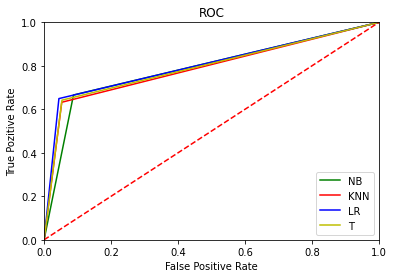

In [ ]:
plt.title("ROC")

plt.plot(fpr_nb, tpr_nb, 'g', label="NB" % roc_auc_nb)
plt.plot(fpr_knn, tpr_knn, 'r', label="KNN" % roc_auc_nb)
plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_nb)
plt.plot(fpr_t, tpr_t, 'y', label="T" % roc_auc_nb)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gridsearch Tree classification y Graficos

In [ ]:
!pip install graphviz
!pip install pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from IPython.display import Image
import pydotplus

#### Grafico previo a optimización Tree Classification

In [ ]:
dot_data1 = tree.export_graphviz(clftree, out_file=None,feature_names= x_train.columns, filled = True)

In [ ]:
graph = pydotplus.graph_from_dot_data(dot_data1)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

#### GridSearch para Tree Classification

In [ ]:
params_grid = { "criterion" : ["gini", "entropy"],
                "min_samples_leaf": [5,10,15,20,None], 
                "max_depth" : [1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,17,None],
                "min_samples_split": [2, 3, 4,None]}

In [ ]:
clftree = tree.DecisionTreeClassifier(random_state=40)

In [ ]:
grid_search = GridSearchCV(clftree, params_grid,
                           n_jobs=-1, scoring='accuracy')

In [ ]:
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=40), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13,
                                       14, 15, 16, 17, None],
                         'min_samples_leaf': [5, 10, 15, 20, None],
                         'min_samples_split': [2, 3, 4, None]},
             scoring='accuracy')

In [ ]:
grid_search.best_score_

0.8713899303591587

In [ ]:
cv_clf = grid_search.best_estimator_

In [ ]:
accuracy_score(y_test, cv_clf.predict(x_test))

0.873335853177103

In [ ]:
confusion_matrix(y_test, cv_clf.predict(x_test))

array([[16782,   710],
       [ 2306,  4013]])

#### Gráfico post optimización Tree Classification

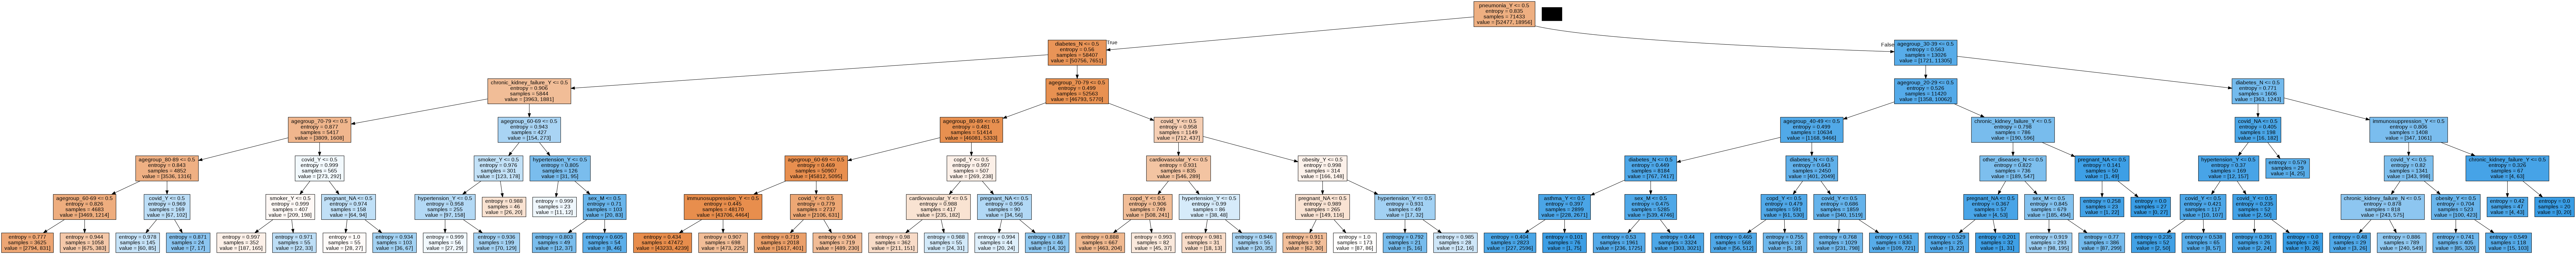

In [ ]:
dot_data = tree.export_graphviz(cv_clf, out_file=None,feature_names= x_train.columns, filled = True)
graph2 = pydotplus.graph_from_dot_data(dot_data)
Image(graph2.create_png())

### GridSearch Para KNN Target Patient Type

In [ ]:
knn=KNeighborsClassifier()

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [ ]:
grid = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')

In [ ]:
#esto tarda una hora más o menos en correr
grid.fit(x_train, y_train)
y_pred_grid = grid.predict(x_test)

In [ ]:
display(grid.best_score_,grid.best_params_,grid.best_estimator_)

In [ ]:
print(confusion_matrix(y_test, y_pred_grid))
print (classification_report(y_test, y_pred_grid))

In [ ]:
random = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=folds, random_state=19)
random.fit(X_train, y_train)
y_pred_grid_random = random.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred_grid_random))
print (classification_report(y_test, y_pred_grid_random))

In [ ]:
display(random.best_score_,random.best_params_,random.best_estimator_)

# Target ICU

## Preparación Datos 

In [ ]:
#Dropeo icu, intubated, death_date
dataI=data.drop(['intubated','death_date'], axis=1)
print(dataI.columns)
dataI.shape

Index(['sex', 'patient_type', 'pneumonia', 'age', 'pregnant', 'diabetes',
       'copd', 'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'outcome', 'icu'],
      dtype='object')


(95252, 17)

In [ ]:
#99 a null y dropeo
cols=dataI.columns.difference(['age'])

df=(dataI[cols] == 99)
ix=df[df.any(axis=1)].index
print(ix)
dataI.drop(df.index[ix], axis=0, inplace=True)
dataI.shape

Int64Index([  161,   174,   592,   609,   644, 13322, 15671, 17561, 21799,
            24103, 27316, 36234, 39750, 52791, 55666, 60589, 71694, 75005,
            75100, 75613, 75928, 77159, 77409, 77847, 79039, 84052, 85155,
            85376, 85689, 86708, 89716],
           dtype='int64')


(95221, 17)

In [ ]:
#Renombro columnas
dataI.rename(columns={"patient_type": "inpatient", "outcome": "covid"},inplace=True)

In [ ]:
#Para predictivas: 1 -> Y, 2 -> N, 
cols = dataI.loc[:, dataI.columns.difference(['age', 'sex','inpatient'])].columns
#print(cols) 
dataI[cols] = dataI[cols].replace([1,2],['Y','N'])

#en sex: 1 -> F y 2-> M
dataI['sex']= dataI['sex'].replace([1,2],['F','M'])

#en pregnant : 98 -> N, 97 -> NA
dataI['pregnant'] = dataI['pregnant'].replace([98,97],['N','NA'])

# outcome: 3 -> NA
dataI['covid'] = dataI['covid'].replace([3],['NA'])

#Para Inpatient: 1 -> 0, 2 -> 1
dataI['inpatient']= dataI['inpatient'].replace([1,2],[0,1])

#Para Target
dataI['icu'] = dataI['icu'].replace([97, 'N', 'Y'], [0,0,1])

dataI.head(5)

,sex,inpatient,pneumonia,age,pregnant,diabetes,copd,asthma,immunosuppression,hypertension,other_diseases,cardiovascular,obesity,chronic_kidney_failure,smoker,covid,icu
0,M,0,N,42,NA,N,N,Y,N,N,N,N,N,N,N,Y,0
1,F,0,N,51,N,N,N,N,N,N,N,N,N,N,N,Y,0
2,M,0,N,51,NA,Y,N,N,N,Y,N,N,Y,N,N,Y,0
3,M,0,N,57,NA,Y,N,N,N,N,N,N,N,N,N,Y,0
4,F,0,N,44,N,Y,N,N,N,N,N,N,N,N,N,N,0


In [ ]:
dataI.icu.unique()

array([0, 1])

In [ ]:
dataI.groupby(["sex","pregnant"])["pregnant"].count()

sex  pregnant
F    N           45904
     Y             975
M    NA          48342
Name: pregnant, dtype: int64

In [ ]:
#creo categorias para edad por décadas (puede ser por etapa biologica niños-jovenes-adultos-ancianos)
dataI = dataI.assign(agegroup=pd.cut(dataI['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False, labels=["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99"]))

In [ ]:
dataI.columns

Index(['sex', 'inpatient', 'pneumonia', 'age', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid', 'icu', 'agegroup'],
      dtype='object')

In [ ]:
#elimino age para no tener dummies
dataI.drop(["age"], axis=1, inplace=True)

In [ ]:
dataI.columns

Index(['sex', 'inpatient', 'pneumonia', 'pregnant', 'diabetes', 'copd',
       'asthma', 'immunosuppression', 'hypertension', 'other_diseases',
       'cardiovascular', 'obesity', 'chronic_kidney_failure', 'smoker',
       'covid', 'icu', 'agegroup'],
      dtype='object')

In [ ]:
#creo variables dummies de todas las columnas menos la target
dataI = pd.get_dummies(data=dataI, columns= dataI.columns.difference(["icu"]),drop_first = True)

In [ ]:
dataI.columns

Index(['icu', 'agegroup_10-19', 'agegroup_20-29', 'agegroup_30-39',
       'agegroup_40-49', 'agegroup_50-59', 'agegroup_60-69', 'agegroup_70-79',
       'agegroup_80-89', 'agegroup_90-99', 'asthma_Y', 'cardiovascular_Y',
       'chronic_kidney_failure_N', 'chronic_kidney_failure_Y', 'copd_Y',
       'covid_NA', 'covid_Y', 'diabetes_N', 'diabetes_Y', 'hypertension_Y',
       'immunosuppression_Y', 'obesity_Y', 'other_diseases_N',
       'other_diseases_Y', 'pneumonia_Y', 'pregnant_NA', 'pregnant_Y', 'sex_M',
       'smoker_Y'],
      dtype='object')

## Creación variables X e Y Target ICU

Eliminamos las columnas death_date, intubated y icu (por su correlación lineal con intubated)

In [ ]:
x=dataI.drop(["icu"],axis=1)
y=dataI["icu"]
y=pd.DataFrame(y)
y

,icu
0,0
1,0
2,0
3,0
4,0
...,...
95247,0
95248,0
95249,0
95250,0


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y)
print ("X_train:" , x_train.shape[0])
print ("y_train:" , y_train.shape[0])
print ("X_test:" , x_test.shape[0])
print ("y_test:" , y_test.shape[0])

X_train: 71415
y_train: 71415
X_test: 23806
y_test: 23806


In [ ]:
y_train=pd.DataFrame(y_train)
y_train

,icu
601,0
40083,0
79380,0
15436,0
22801,0
...,...
19450,0
935,0
43075,0
47916,0


## Logistic Regression Target ICU

In [ ]:
#Logistic regression
#scaler = StandardScaler()
#x_trainstd = scaler.fit_transform(x_train)
#x_teststd = scaler.transform(x_test)
lr = LogisticRegression(class_weight="balance")
lr.fit(x_train, y_train)
score_lr= lr.score(x_test, y_test)

In [ ]:
print ("Logistic Regression Score:", score_lr)

Logistic Regression Score: 0.9776946988154247


In [ ]:
y_pred_lr = lr.predict(x_test)

In [ ]:
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))

AS LR:
 0.9776946988154247


In [ ]:
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))

CM LR:
 [[23275     0]
 [  531     0]]


In [ ]:
lr.intercept_

array([0.21811683])

In [ ]:
lr.coef_

array([[-1.16076268, -1.85751468, -1.83519481, -1.50032629, -1.10912017,
        -0.68241957, -0.17604845,  0.18634915,  0.66417885, -0.1421404 ,
         0.16684014, -0.0498836 ,  1.16096044,  0.59742408,  0.39701144,
         0.63737348, -0.89843473, -0.2769965 ,  0.21193756,  0.98091411,
         0.14195396, -0.53830832, -0.04313686,  3.45495375,  1.81458678,
         0.31708228,  0.03659199]])

In [ ]:
print("LR:\n", classification_report(y_test,y_pred_lr))

LR:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     23275
           1       0.00      0.00      0.00       531

    accuracy                           0.98     23806
   macro avg       0.49      0.50      0.49     23806
weighted avg       0.96      0.98      0.97     23806



In [ ]:
importance = lr.coef_.flatten()

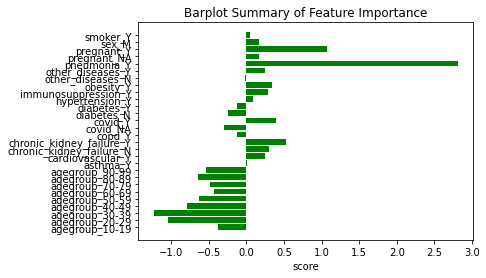

In [ ]:
plt.barh(x.columns,importance,color="g")
plt.title("Barplot Summary of Feature Importance")
plt.xlabel("score")
plt.show()

In [ ]:
#LR
probs_lr=lr.predict_proba(x_test)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

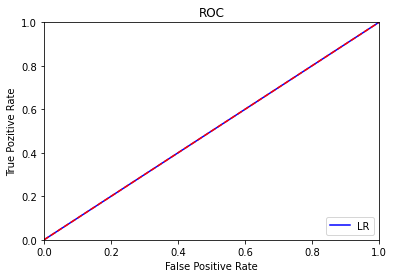

In [ ]:
plt.title("ROC")

plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_lr)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Machine Learning Algorithms Target ICU



In [ ]:
#Naive Bayes
nb=MultinomialNB()
nb.fit(x_train, y_train)
score_nb=nb.score(x_test,y_test)

#KNN (poner en n_neighbors el best_params_ de GridSearch)
knn=KNeighborsClassifier(n_neighbors=20)
knn.fit(x_train,y_train)
score_knn=knn.score(x_test,y_test)

#Logistic regression
scaler = StandardScaler()
x_trainstd = scaler.fit_transform(x_train)
x_teststd = scaler.transform(x_test)
lr = LogisticRegression()
lr.fit(x_trainstd, y_train)
score_lr= lr.score(x_teststd, y_test)

#Score
print ("Naive Bayes Acc Score:",score_nb)
print ("KNN Acc Score:",score_knn)
print ("Logistic Regression Score:", score_lr)

Naive Bayes Acc Score: 0.9720658657481307
KNN Acc Score: 0.9776946988154247
Logistic Regression Score: 0.9776946988154247


In [ ]:
y_pred_nb = nb.predict(x_test)
y_pred_knn = knn.predict(x_test)
y_pred_lr = lr.predict(x_teststd)

In [ ]:
print("AS NB:\n", accuracy_score(y_test, y_pred_nb))
print("AS KNN:\n", accuracy_score(y_test, y_pred_knn))
print("AS LR:\n", accuracy_score(y_test, y_pred_lr))

AS NB:
 0.9720658657481307
AS KNN:
 0.9776946988154247
AS LR:
 0.9776946988154247


In [ ]:
#usar cross validation Stratified K-fold porque el target está desbalanceado
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.linear_model import LogisticRegression
iris=load_iris()
X=iris.data
Y=iris.target
logreg=LogisticRegression()
stratifiedkf=StratifiedKFold(n_splits=5)
score=cross_val_score(logreg,X,Y,cv=stratifiedkf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

## Confusion_matrix Target ICU

In [ ]:
print("CM NB:\n", confusion_matrix(y_test, y_pred_nb))
print("CM KNN:\n", confusion_matrix(y_test, y_pred_knn))
print("CM LR:\n", confusion_matrix(y_test, y_pred_lr))

CM NB:
 [[23121   154]
 [  511    20]]
CM KNN:
 [[23275     0]
 [  531     0]]
CM LR:
 [[23275     0]
 [  531     0]]


## Recall,Precision and F-1 Score Target ICU


* Recall    =  TP / (TP + FN)
* Precision = TP / (TP + FP) 
* F-Measure = (2 * Precision * Recall) / (Precision + Recall)

In [ ]:
print("NB:\n", classification_report(y_test,y_pred_nb))
print("KNN:\n", classification_report(y_test,y_pred_knn))
print("LR:\n", classification_report(y_test,y_pred_lr))

NB:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     23275
           1       0.11      0.04      0.06       531

    accuracy                           0.97     23806
   macro avg       0.55      0.52      0.52     23806
weighted avg       0.96      0.97      0.97     23806

KNN:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     23275
           1       0.00      0.00      0.00       531

    accuracy                           0.98     23806
   macro avg       0.49      0.50      0.49     23806
weighted avg       0.96      0.98      0.97     23806

LR:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     23275
           1       0.00      0.00      0.00       531

    accuracy                           0.98     23806
   macro avg       0.49      0.50      0.49     23806
weighted avg       0.96      0.98      0.97     23806



In [ ]:
print ("F1 Score NB:", f1_score(y_test,y_pred_nb))
print ("F1 Score KNN:", f1_score(y_test,y_pred_knn))
print ("F1 Score LR:", f1_score(y_test,y_pred_lr))

F1 Score NB: 0.05673758865248227
F1 Score KNN: 0.0
F1 Score LR: 0.0


## roc & auc Target ICU

In [ ]:
#NB
probs_nb=nb.predict_proba(x_test)
preds_nb=probs_nb[:,1]
fpr_nb,tpr_nb, threshold_nb =metrics.roc_curve(y_test, y_pred_nb)
roc_auc_nb=metrics.auc(fpr_nb,tpr_nb)

#KNN
probs_knn=knn.predict_proba(x_test)
preds_knn=probs_knn[:,1]
fpr_knn,tpr_knn, threshold_knn =metrics.roc_curve(y_test, y_pred_knn)
roc_auc_knn=metrics.auc(fpr_knn,tpr_knn)

#LR
probs_lr=lr.predict_proba(x_teststd)
preds_lr=probs_lr[:,1]
fpr_lr,tpr_lr, threshold_lr =metrics.roc_curve(y_test, y_pred_lr)
roc_auc_lr=metrics.auc(fpr_lr,tpr_lr)

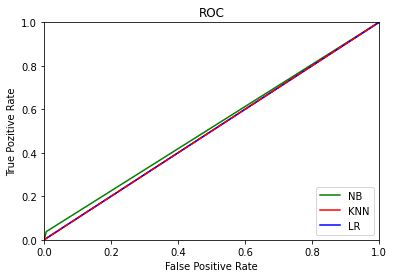

In [ ]:
plt.title("ROC")

plt.plot(fpr_nb, tpr_nb, 'g', label="NB" % roc_auc_nb)
plt.plot(fpr_knn, tpr_knn, 'r', label="KNN" % roc_auc_nb)
plt.plot(fpr_lr, tpr_lr, 'b', label="LR" % roc_auc_nb)

plt.legend(loc="lower right")
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Pozitive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### GridSearch Para KNN Target ICU

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
knn=KNeighborsClassifier()

k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

folds=StratifiedKFold(n_splits=10, random_state=19, shuffle=True)

In [ ]:
grid = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')

In [ ]:
#esto tarda una hora más o menos en correr
grid.fit(x_train, y_train)
y_pred_grid = grid.predict(x_test)

In [ ]:
display(grid.best_score_,grid.best_params_,grid.best_estimator_)

In [ ]:
print(confusion_matrix(y_test, y_pred_grid))
print (classification_report(y_test, y_pred_grid))

In [ ]:
random = RandomizedSearchCV(knn, param_grid, n_iter=10, cv=folds, random_state=19)
random.fit(X_train, y_train)
y_pred_grid_random = random.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, y_pred_grid_random))
print (classification_report(y_test, y_pred_grid_random))

In [ ]:
display(random.best_score_,random.best_params_,random.best_estimator_)